## EDA on the CEMBL dataset

In [3]:
import pandas as pd
df = pd.read_csv("dopamine_bioactivity_data_curated.csv")

##Installing conda and RDKIT

In [4]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-09-14 06:59:11--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   167MB/s    in 0.5s    

2021-09-14 06:59:12 (167 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [5]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,20.0,active
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,57.0,active
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,3.0,active
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,16.0,active
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,3.0,active
...,...,...,...,...
271,CHEMBL4453069,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1,100000.0,inactive
272,CHEMBL4456754,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1,100000.0,inactive
273,CHEMBL20734,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,98.2,active
274,CHEMBL4476784,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1,50000.0,inactive


In [6]:
#Dropping the smiles column to use rdkit for feature generation
df_no_smiles = df.drop(columns='canonical_smiles')

In [10]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)
smiles = pd.Series(smiles, name = 'canonical_smiles')


In [14]:

df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles


,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL303519,20.0,active,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1,CHEMBL292943,57.0,active,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2,CHEMBL61682,3.0,active,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1
3,CHEMBL64487,16.0,active,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1
4,CHEMBL64597,3.0,active,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1
...,...,...,...,...
271,CHEMBL4453069,100000.0,inactive,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1
272,CHEMBL4456754,100000.0,inactive,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1
273,CHEMBL20734,98.2,active,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl
274,CHEMBL4476784,50000.0,inactive,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1


In [16]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [17]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [18]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,342.446,3.3700,0.0,4.0
1,360.461,3.4744,0.0,5.0
2,365.427,4.3490,0.0,3.0
3,360.461,3.4744,0.0,5.0
4,336.464,3.5273,0.0,5.0
...,...,...,...,...
271,298.350,0.6323,1.0,6.0
272,332.795,1.2857,1.0,6.0
273,387.911,3.7831,2.0,4.0
274,379.460,3.0133,1.0,4.0


In [19]:
# Combining data frame
df_combined = pd.concat([df,df_lipinski], axis=1)

In [20]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,20.0,active,342.446,3.3700,0.0,4.0
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,57.0,active,360.461,3.4744,0.0,5.0
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,3.0,active,365.427,4.3490,0.0,3.0
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,16.0,active,360.461,3.4744,0.0,5.0
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,3.0,active,336.464,3.5273,0.0,5.0
...,...,...,...,...,...,...,...,...
271,CHEMBL4453069,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1,100000.0,inactive,298.350,0.6323,1.0,6.0
272,CHEMBL4456754,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1,100000.0,inactive,332.795,1.2857,1.0,6.0
273,CHEMBL20734,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,98.2,active,387.911,3.7831,2.0,4.0
274,CHEMBL4476784,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1,50000.0,inactive,379.460,3.0133,1.0,4.0


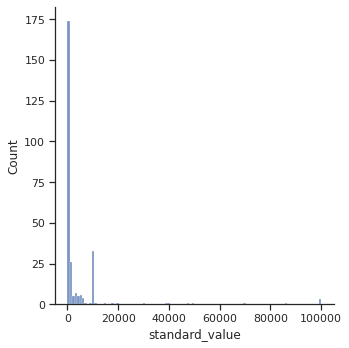

In [66]:
target1= sns.displot(df_combined, x="standard_value")

#Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10$^{-9}$
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [21]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [22]:

df_combined.standard_value.describe()

count       276.000000
mean       4517.328873
std       13570.766830
min           0.057000
25%          38.000000
50%         220.000000
75%        3190.327500
max      100000.000000
Name: standard_value, dtype: float64

In [23]:

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [24]:
#We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [25]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,active,342.446,3.3700,0.0,4.0,20.0
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,active,360.461,3.4744,0.0,5.0,57.0
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,active,365.427,4.3490,0.0,3.0,3.0
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,active,360.461,3.4744,0.0,5.0,16.0
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,active,336.464,3.5273,0.0,5.0,3.0
...,...,...,...,...,...,...,...,...
271,CHEMBL4453069,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1,inactive,298.350,0.6323,1.0,6.0,100000.0
272,CHEMBL4456754,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1,inactive,332.795,1.2857,1.0,6.0,100000.0
273,CHEMBL20734,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,active,387.911,3.7831,2.0,4.0,98.2
274,CHEMBL4476784,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1,inactive,379.460,3.0133,1.0,4.0,50000.0


In [26]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,active,342.446,3.3700,0.0,4.0,7.698970
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,active,360.461,3.4744,0.0,5.0,7.244125
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,active,365.427,4.3490,0.0,3.0,8.522879
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,active,360.461,3.4744,0.0,5.0,7.795880
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,active,336.464,3.5273,0.0,5.0,8.522879
...,...,...,...,...,...,...,...,...
271,CHEMBL4453069,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1,inactive,298.350,0.6323,1.0,6.0,4.000000
272,CHEMBL4456754,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1,inactive,332.795,1.2857,1.0,6.0,4.000000
273,CHEMBL20734,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,active,387.911,3.7831,2.0,4.0,7.007889
274,CHEMBL4476784,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1,inactive,379.460,3.0133,1.0,4.0,4.301030


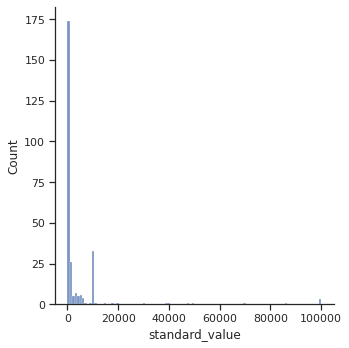

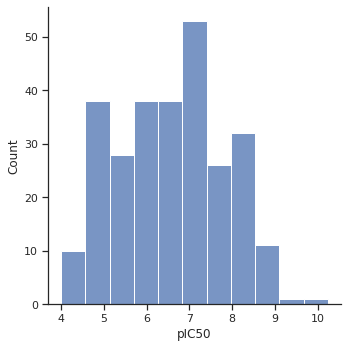

In [70]:
target1= sns.displot(df_combined, x="standard_value")
target2= sns.displot(df_final, x="pIC50")
plt.show()

In [27]:
df_final.to_csv('dopamine_pIC50.csv')

In [28]:
#Remove Intermediate class
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL303519,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,active,342.446,3.3700,0.0,4.0,7.698970
1,CHEMBL292943,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,active,360.461,3.4744,0.0,5.0,7.244125
2,CHEMBL61682,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,active,365.427,4.3490,0.0,3.0,8.522879
3,CHEMBL64487,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,active,360.461,3.4744,0.0,5.0,7.795880
4,CHEMBL64597,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,active,336.464,3.5273,0.0,5.0,8.522879
...,...,...,...,...,...,...,...,...
271,CHEMBL4453069,O=C(CN1CCN(c2ccccn2)CC1)Nc1cncnc1,inactive,298.350,0.6323,1.0,6.0,4.000000
272,CHEMBL4456754,O=C(CN1CCN(c2ccc(Cl)cn2)CC1)Nc1cncnc1,inactive,332.795,1.2857,1.0,6.0,4.000000
273,CHEMBL20734,CNc1cc(OC)c(C(=O)NC2CCN(Cc3ccccc3)C2C)cc1Cl,active,387.911,3.7831,2.0,4.0,7.007889
274,CHEMBL4476784,COc1ccc(OCCN2CCN(C(=O)c3cc4ccccc4[nH]3)CC2)cc1,inactive,379.460,3.0133,1.0,4.0,4.301030


In [29]:
#EDA
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

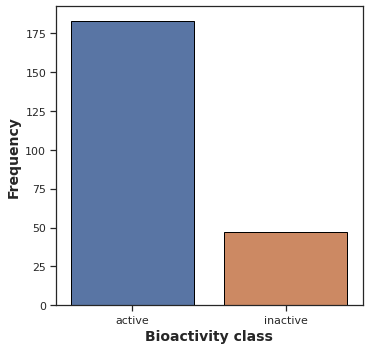

In [30]:
#Frequency plot
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

# Scatter plot of MW versus LogP
It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP 


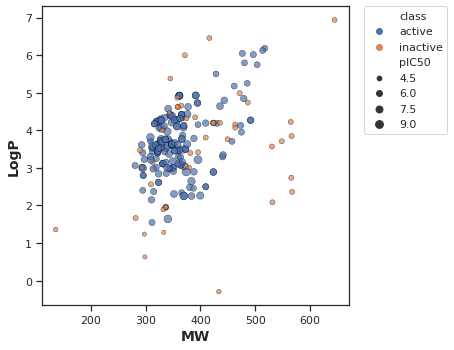

In [56]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

In [54]:

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [57]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.768585e-26,0.05,Different distribution (reject H0)


In [58]:

mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,3301.0,0.00704,0.05,Different distribution (reject H0)


In [36]:

mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,4101.5,0.312831,0.05,Same distribution (fail to reject H0)


In [37]:

mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2581.0,6.591094e-07,0.05,Different distribution (reject H0)


In [38]:

mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,3590.0,0.035596,0.05,Different distribution (reject H0)


In [39]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: plot_bioactivity_class.pdf (deflated 39%)
  adding: plot_MW_vs_LogP.pdf (deflated 10%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 12%)
  adding: dopamine_bioactivity_data_curated.csv (deflated 79%)
  adding: dopamine_pIC50.csv (deflated 75%)
  adding: df_clean_smiles.csv (deflated 77%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)


In [59]:
def kruskal(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import kruskal

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = kruskal(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'kruskal_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [60]:
kruskal("LogP")

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,0.23919,0.624792,0.05,Same distribution (fail to reject H0)
